In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import feature.scrna_dataset as scrna_dataset
import model.sdes as sdes
import model.generate as generate
import model.scrna_ae as scrna_ae
import model.util as model_util
import analysis.fid as fid
import torch
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import os
import h5py

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the branches and create the data loader

In [3]:
# classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

classes = [0, 1, 2, 3, 4, 5, 7, 10, 12]

# classes = [0]

# classes = [0, 1, 5]

In [4]:
data_file = "/gstore/data/resbioai/tsenga5/branched_diffusion/data/scrna/covid_flu/processed/covid_flu_processed_reduced_genes.h5"
autoencoder_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/scrna_vaes/covid_flu/covid_flu_processed_reduced_genes_ldvae_d100/"

dataset = scrna_dataset.SingleCellDataset(data_file, autoencoder_path=autoencoder_path)

# Limit classes
inds = np.isin(dataset.cell_cluster, classes)
dataset.data = dataset.data[inds]
dataset.cell_cluster = dataset.cell_cluster[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)
input_shape = next(iter(data_loader))[0].shape[1:]

[rank: 0] Global seed set to 0


INFO     File                                                                                                      
         /gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/scrna_vaes/covid_flu/covid_flu_proc
         essed_reduced_genes_ldvae_d100/model.pt already downloaded                                                


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/gstore/home/tsenga5/miniconda3/envs/scanpy/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [5]:
# Import gene names and marker genes
with h5py.File(data_file, "r") as f:
    gene_names = f["gene_names"][:].astype(str)
    marker_genes = {}
    for class_i in classes:
        marker_genes[class_i] = f["marker_genes"][str(class_i)][:].astype(str)
    
genes_of_interest = np.array(["NFKB1", "NFKB2", "IRF1", "CXCR3", "CXCL10", "STAT1", "TLR4", "TGFB1", "IL1B", "IFNG", "TLR4", "TNFSF4", "IL1R2", "IL1B", "IL7R", "IL32"])

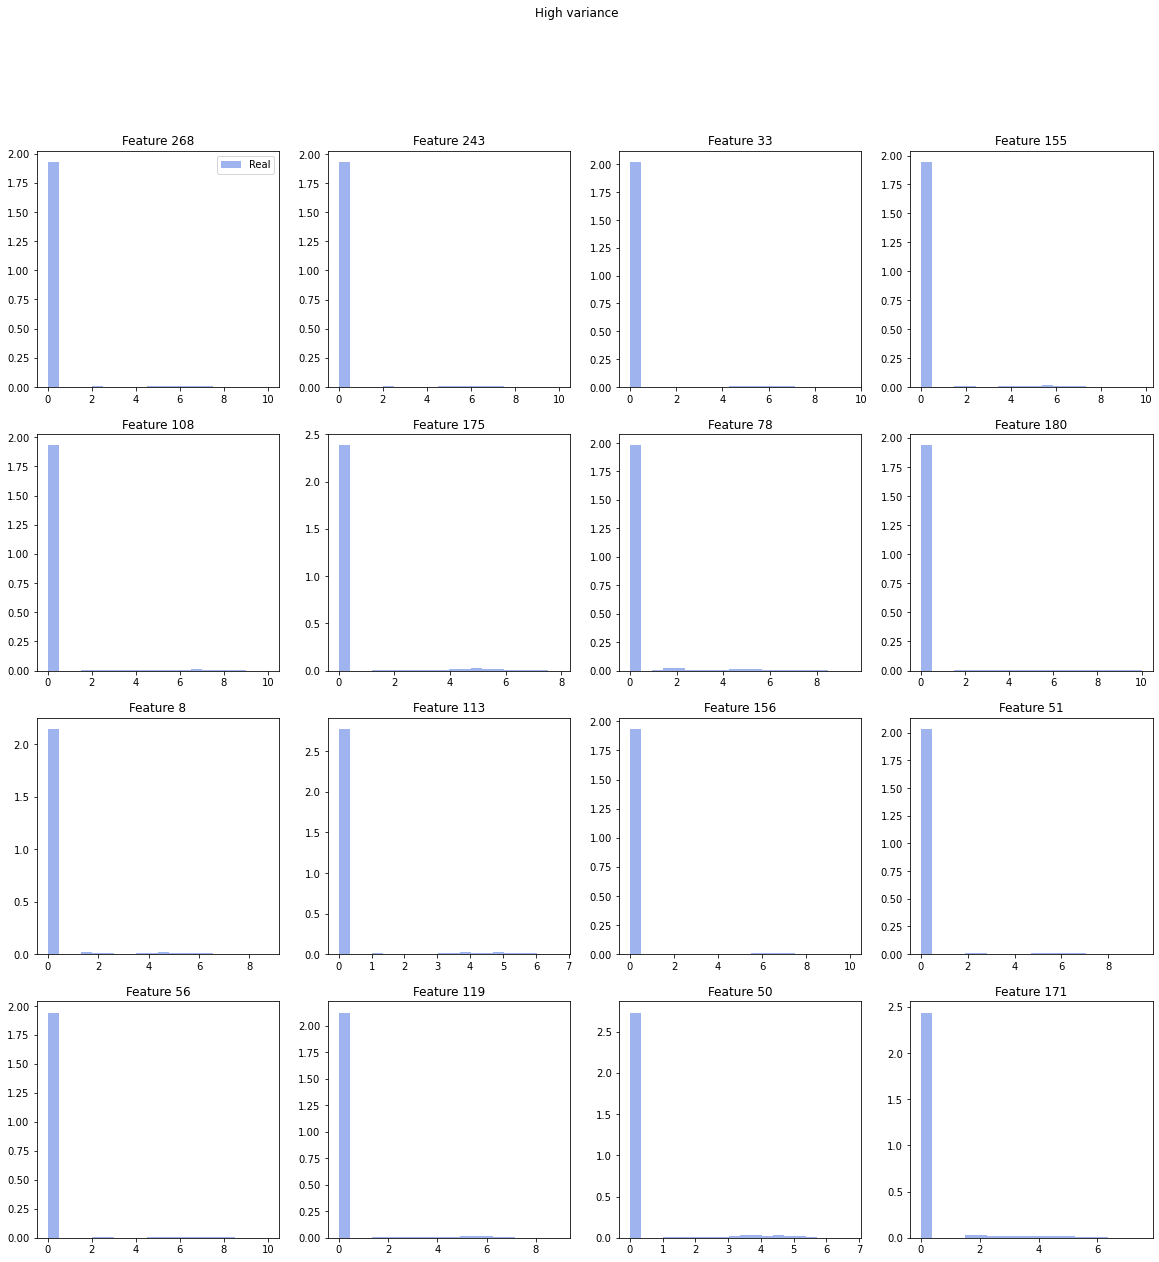

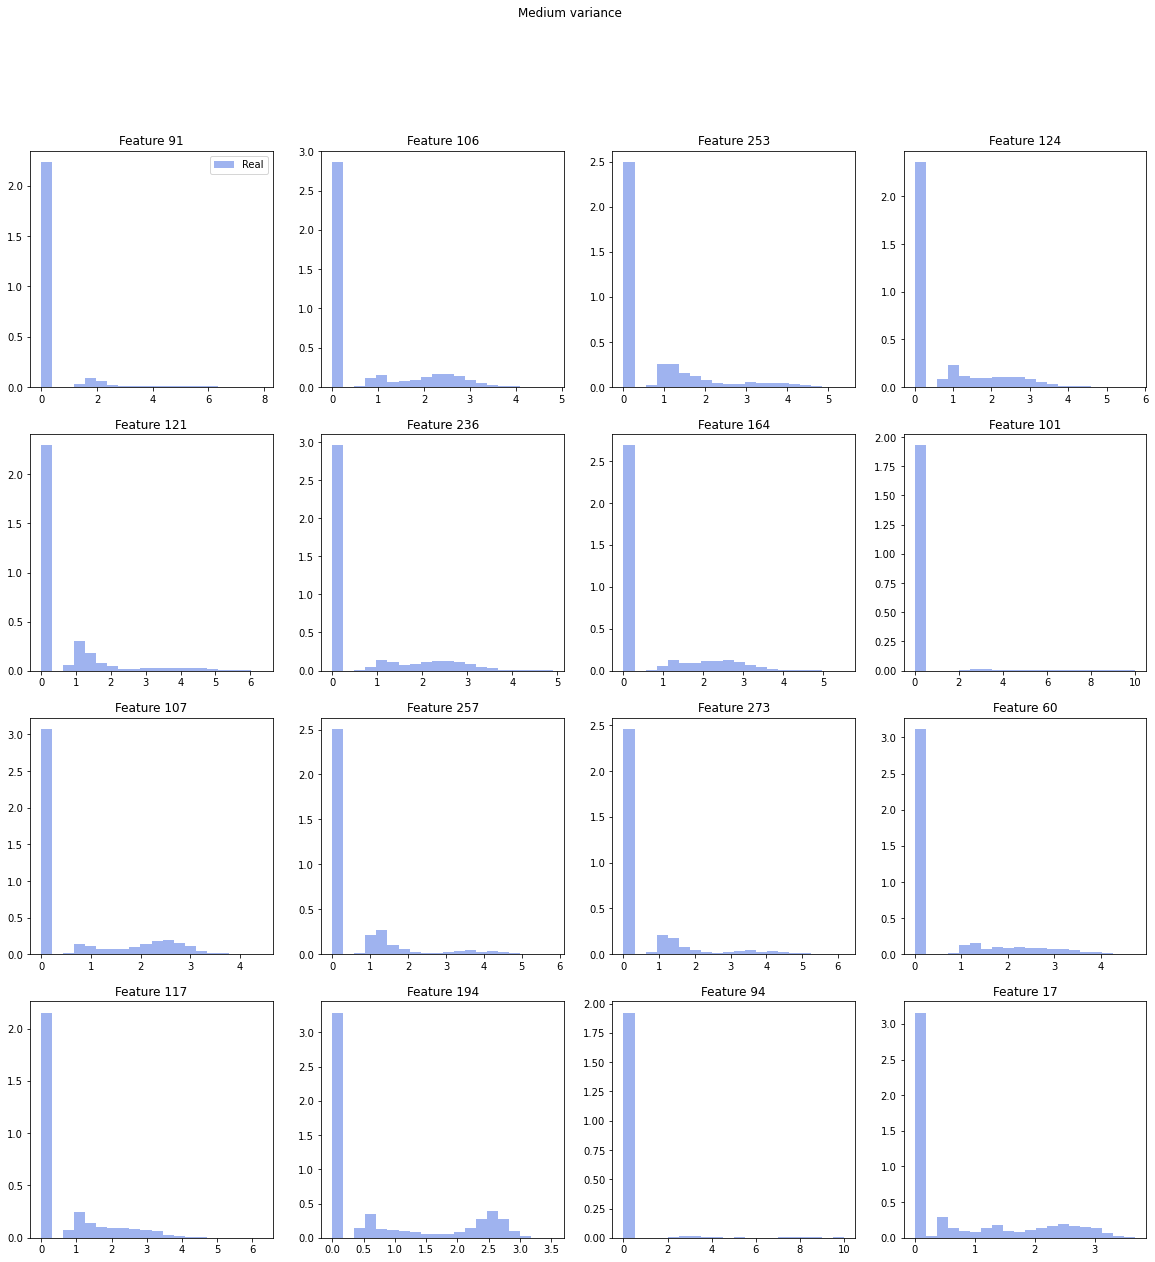

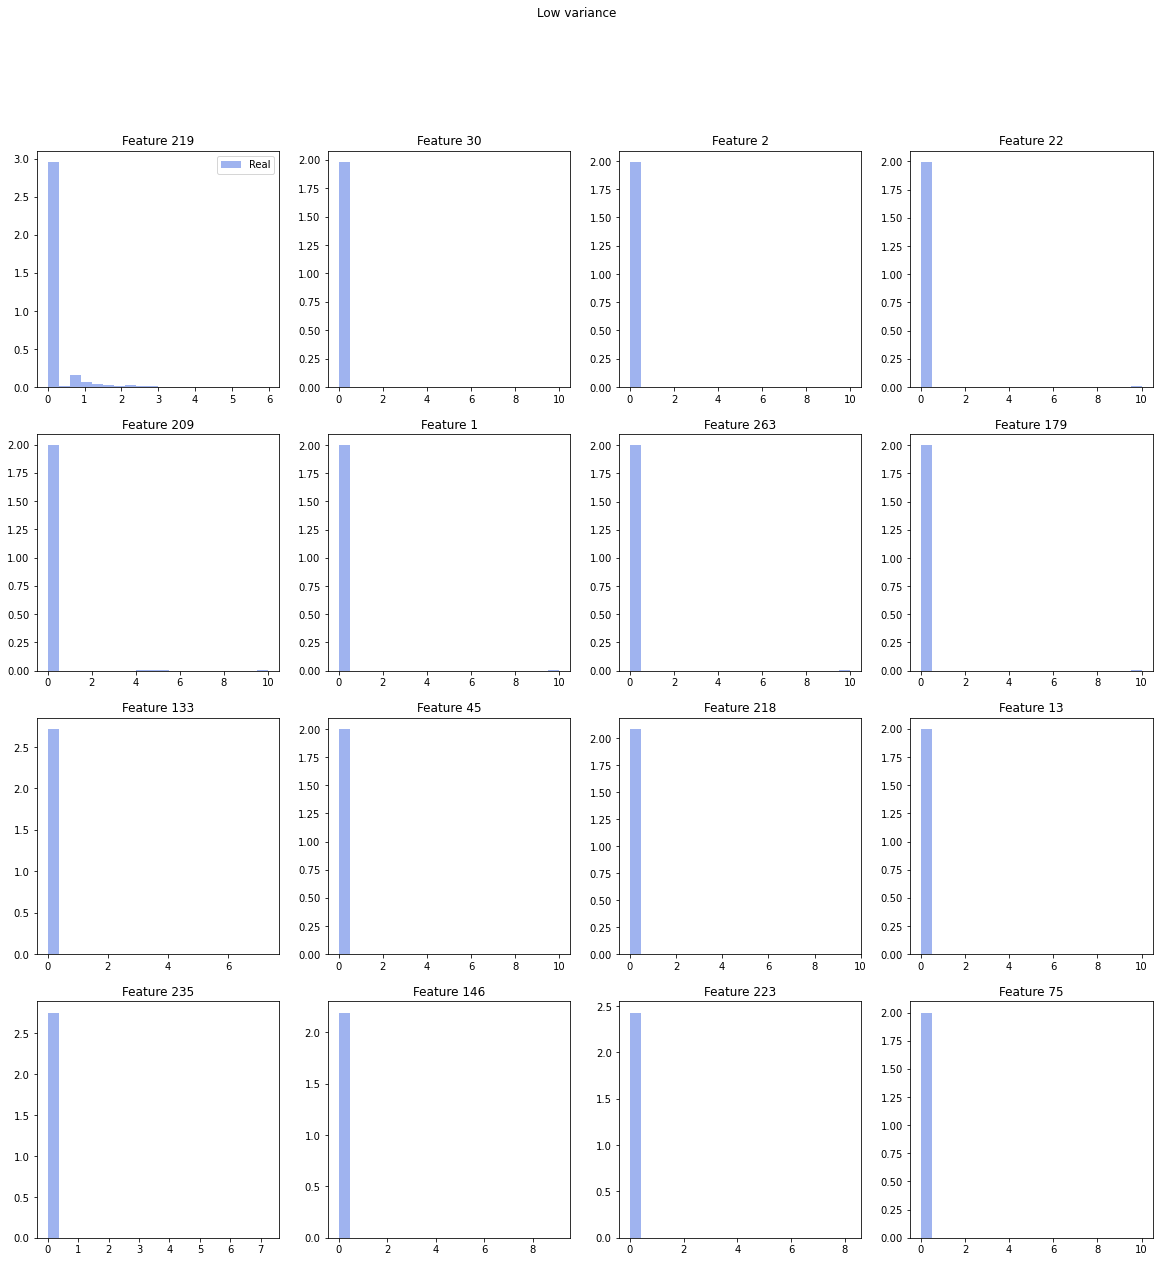

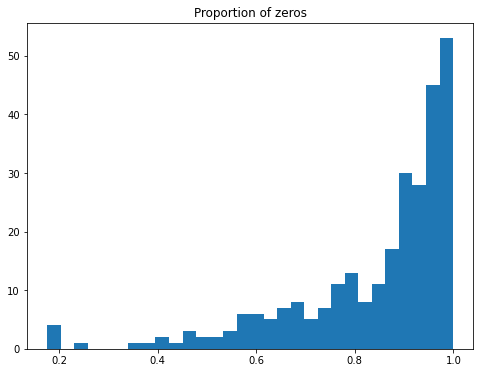

In [6]:
# Plot features
x = dataset.data
inds = np.flip(np.argsort(np.std(x, axis=0)))
num_features = 16
num_cols = 4
num_rows = int(np.ceil(num_features / num_cols))
num_bins = 20

for name, feature_inds in [
    ("High variance", inds[:num_features]),
    ("Medium variance", inds[(len(inds) // 2) - (num_features // 2):(len(inds) // 2) - (num_features // 2) + num_features]),
    ("Low variance", inds[-num_features:])
]:
    fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
    for i, f_i in enumerate(feature_inds):
        r, c = i // num_cols, i % num_cols
        vals = x[:, f_i]
        ax[r][c].hist(vals, bins=num_bins, color="royalblue", label="Real", density=True, alpha=0.5)
        ax[r][c].set_title("Feature %d" % f_i)
    ax[0][0].legend()
    fig.suptitle(name)
    plt.show()
    
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(np.sum(x == 0, axis=0) / x.shape[0], bins=30)
ax.set_title("Proportion of zeros")
plt.show()

In [7]:
def class_to_class_index_tensor(c):
    """
    Given a tensor of classes, return the corresponding class indices
    as a tensor.
    """
    return torch.argmax(
        (c[:, None] == torch.tensor(classes, device=c.device)).int(), dim=1
    ).to(DEVICE)

In [8]:
# Create the SDE and model
sde = sdes.VariancePreservingSDE(0.1, 5, input_shape)

t_limit = 1

model = scrna_ae.LabelGuidedResNet(
    len(classes), input_shape[0], t_limit=t_limit
).to(DEVICE)

os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/scrna_covid_flu_continuous_cellslimited_latent_d100_labelguided"
import model.train_continuous_model as train_continuous_model  # Import this AFTER setting environment

### Show the forward-diffusion process

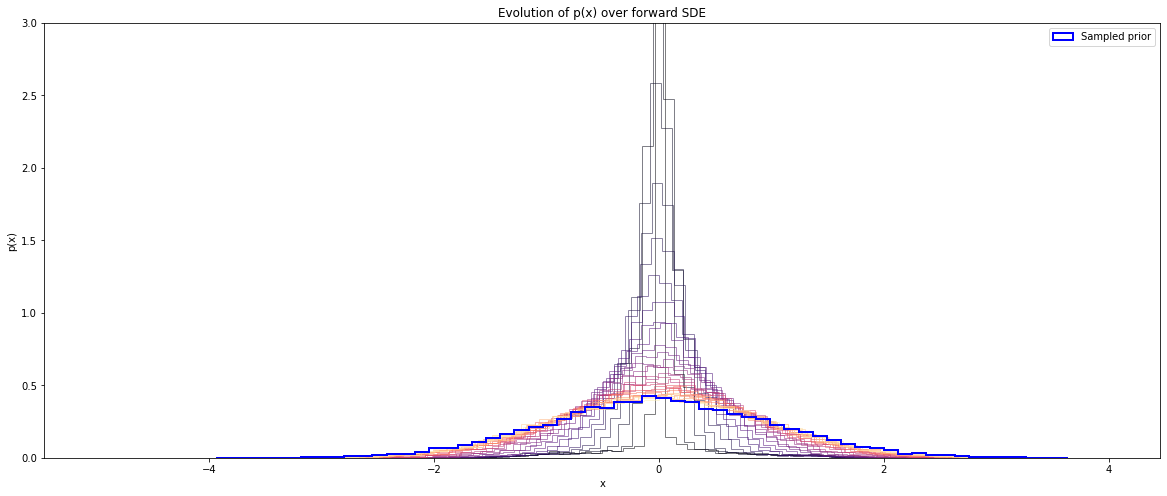

In [9]:
# Show the transformation of the distribution of data to the prior distribution
x0, _ = next(iter(data_loader))
x0 = x0.cpu().numpy()
x0 = torch.tensor(x0).to(DEVICE)

time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = sde.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = sde.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward SDE")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

### Train the model

In [10]:
train_continuous_model.train_ex.run(
    "train_label_guided_model",
    config_updates={
        "model": model,
        "sde": sde,
        "data_loader": data_loader,
        "class_to_class_index": class_to_class_index_tensor,
        "num_epochs": 30,
        "learning_rate": 1e-3,
        "t_limit": t_limit,
        "loss_weighting_type": "empirical_norm"
    }
)

WARNING - root - Added new config entry: "class_to_class_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_label_guided_model'
/gstore/home/tsenga5/miniconda3/envs/scanpy/lib/python3.9/site-packages/jsonpickle/ext/numpy.py:291: UserWarning: ndarray is defined by reference to an object we do not know how to serialize. A deep copy is serialized instead, breaking memory aliasing.
  warnings.warn(msg)
INFO - train - Started run with ID "1"
Loss: 31.28: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [04:23<00:00,  1.06s/it]


Epoch 1 average Loss: 108.88


Loss: 23.87: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:47<00:00,  2.30it/s]


Epoch 2 average Loss: 22.75


Loss: 29.36: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:21<00:00,  3.05it/s]


Epoch 3 average Loss: 20.83


Loss: 32.32: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:22<00:00,  3.01it/s]


Epoch 4 average Loss: 18.85


Loss: 58.06: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:21<00:00,  3.04it/s]


Epoch 5 average Loss: 17.79


Loss: 23.07: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:19<00:00,  3.13it/s]


Epoch 6 average Loss: 16.16


Loss: 23.89: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:19<00:00,  3.12it/s]


Epoch 7 average Loss: 14.94


Loss: 22.56: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:19<00:00,  3.11it/s]


Epoch 8 average Loss: 14.08


Loss: 28.53: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:19<00:00,  3.11it/s]


Epoch 9 average Loss: 13.71


Loss: 23.68: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:20<00:00,  3.10it/s]


Epoch 10 average Loss: 12.76


Loss: 19.74: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:19<00:00,  3.11it/s]


Epoch 11 average Loss: 12.28


Loss: 55.38: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:19<00:00,  3.12it/s]


Epoch 12 average Loss: 11.89


Loss: 33.73: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:19<00:00,  3.13it/s]


Epoch 13 average Loss: 11.67


Loss: 483.98: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:19<00:00,  3.11it/s]


Epoch 14 average Loss: 13.01


Loss: 19.60: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:19<00:00,  3.11it/s]


Epoch 15 average Loss: 10.83


Loss: 57.38: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:19<00:00,  3.10it/s]


Epoch 16 average Loss: 10.53


Loss: 26.13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:19<00:00,  3.12it/s]


Epoch 17 average Loss: 10.44


Loss: 21.92: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:19<00:00,  3.11it/s]


Epoch 18 average Loss: 10.04


Loss: 96.97: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:19<00:00,  3.11it/s]


Epoch 19 average Loss: 10.08


Loss: 64.87: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:19<00:00,  3.11it/s]


Epoch 20 average Loss: 9.80


Loss: 466.91: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:19<00:00,  3.11it/s]


Epoch 21 average Loss: 11.31


Loss: 40.17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:19<00:00,  3.11it/s]


Epoch 22 average Loss: 9.47


Loss: 21.83: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:19<00:00,  3.12it/s]


Epoch 23 average Loss: 9.36


Loss: 20.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:19<00:00,  3.12it/s]


Epoch 24 average Loss: 9.13


Loss: 17.79: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:19<00:00,  3.12it/s]


Epoch 25 average Loss: 8.90


Loss: 25.98: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:19<00:00,  3.12it/s]


Epoch 26 average Loss: 8.84


Loss: 75.79: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:19<00:00,  3.13it/s]


Epoch 27 average Loss: 8.99


Loss: 27.84: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:19<00:00,  3.12it/s]


Epoch 28 average Loss: 8.77


Loss: 17.03: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:19<00:00,  3.11it/s]


Epoch 29 average Loss: 8.73


Loss: 86.43: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [01:19<00:00,  3.12it/s]


Epoch 30 average Loss: 8.89


INFO - train - Completed after 0:45:10


### Show generated distributions

In [11]:
samples = {}
for class_to_sample in classes:
    sample = generate.generate_continuous_label_guided_samples(
        model, sde, class_to_sample, class_to_class_index_tensor,
        sampler="pc", t_limit=t_limit, num_steps=1000, verbose=True
    )
    samples[class_to_sample] = dataset.decode_batch(sample).cpu().numpy()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.83it/s]


In [12]:
# For simplicity, sample a lot of inputs for the real data
data, targets = [], []
for _ in range(len(classes)):
    x, y = next(iter(data_loader))
    data.append(dataset.decode_batch(x).cpu().numpy())
    targets.append(y.cpu().numpy())
data = np.concatenate(data)
targets = np.concatenate(targets)

In [13]:
# Rescale sampled values to match range of true values based on standard deviation
def rescale_samples(samps, samp_class):
    t = data[targets == samp_class]

    s_z = (samps - np.mean(samps, axis=0, keepdims=True)) / np.std(samps, axis=0, keepdims=True)
    s_trans = (s_z * np.std(t, axis=0, keepdims=True)) + np.mean(t, axis=0, keepdims=True)
    
    return np.nan_to_num(s_trans)  # Convert NaNs to 0s

samples_scaled = {}
for class_to_sample in classes:
    samples_scaled[class_to_sample] = rescale_samples(samples[class_to_sample], class_to_sample)

Class 0


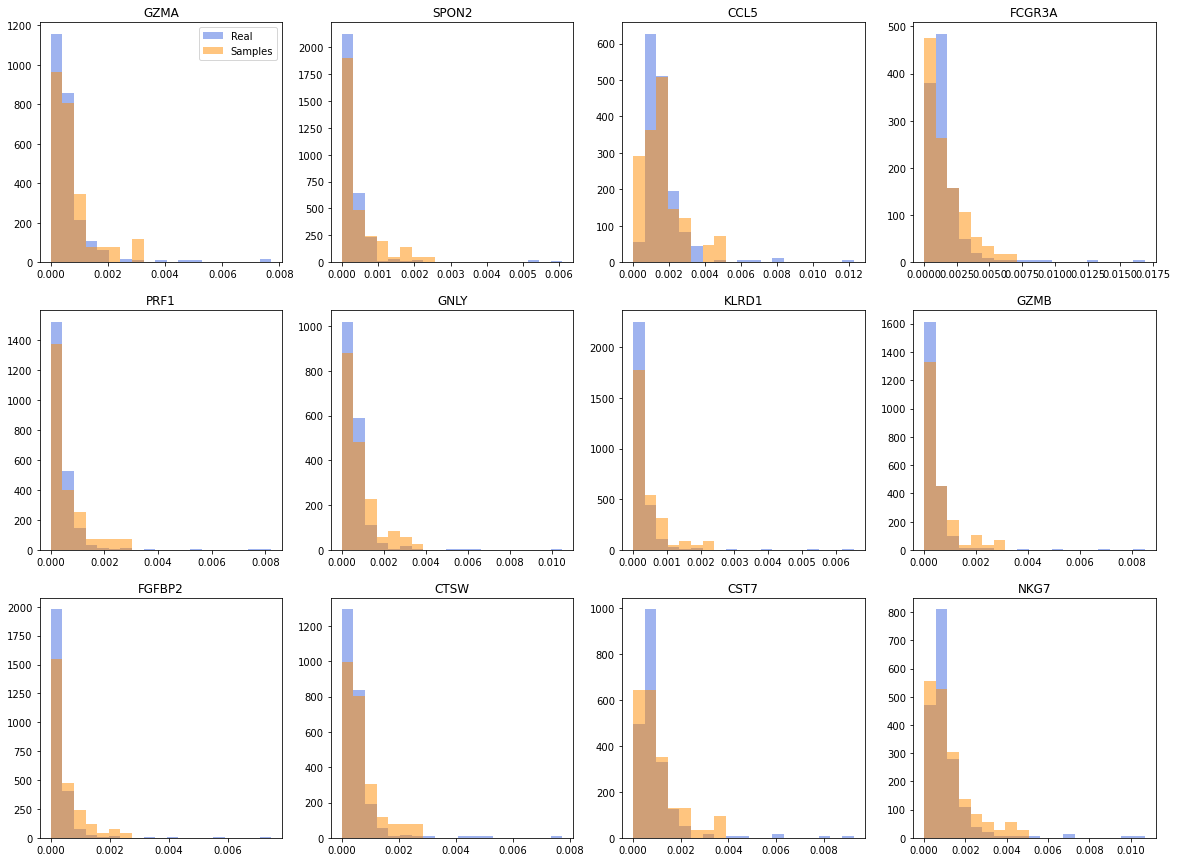

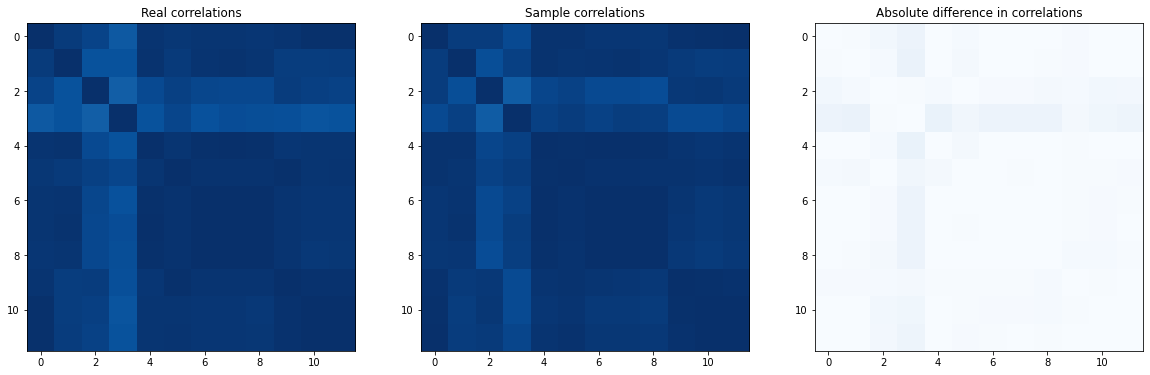

Class 1


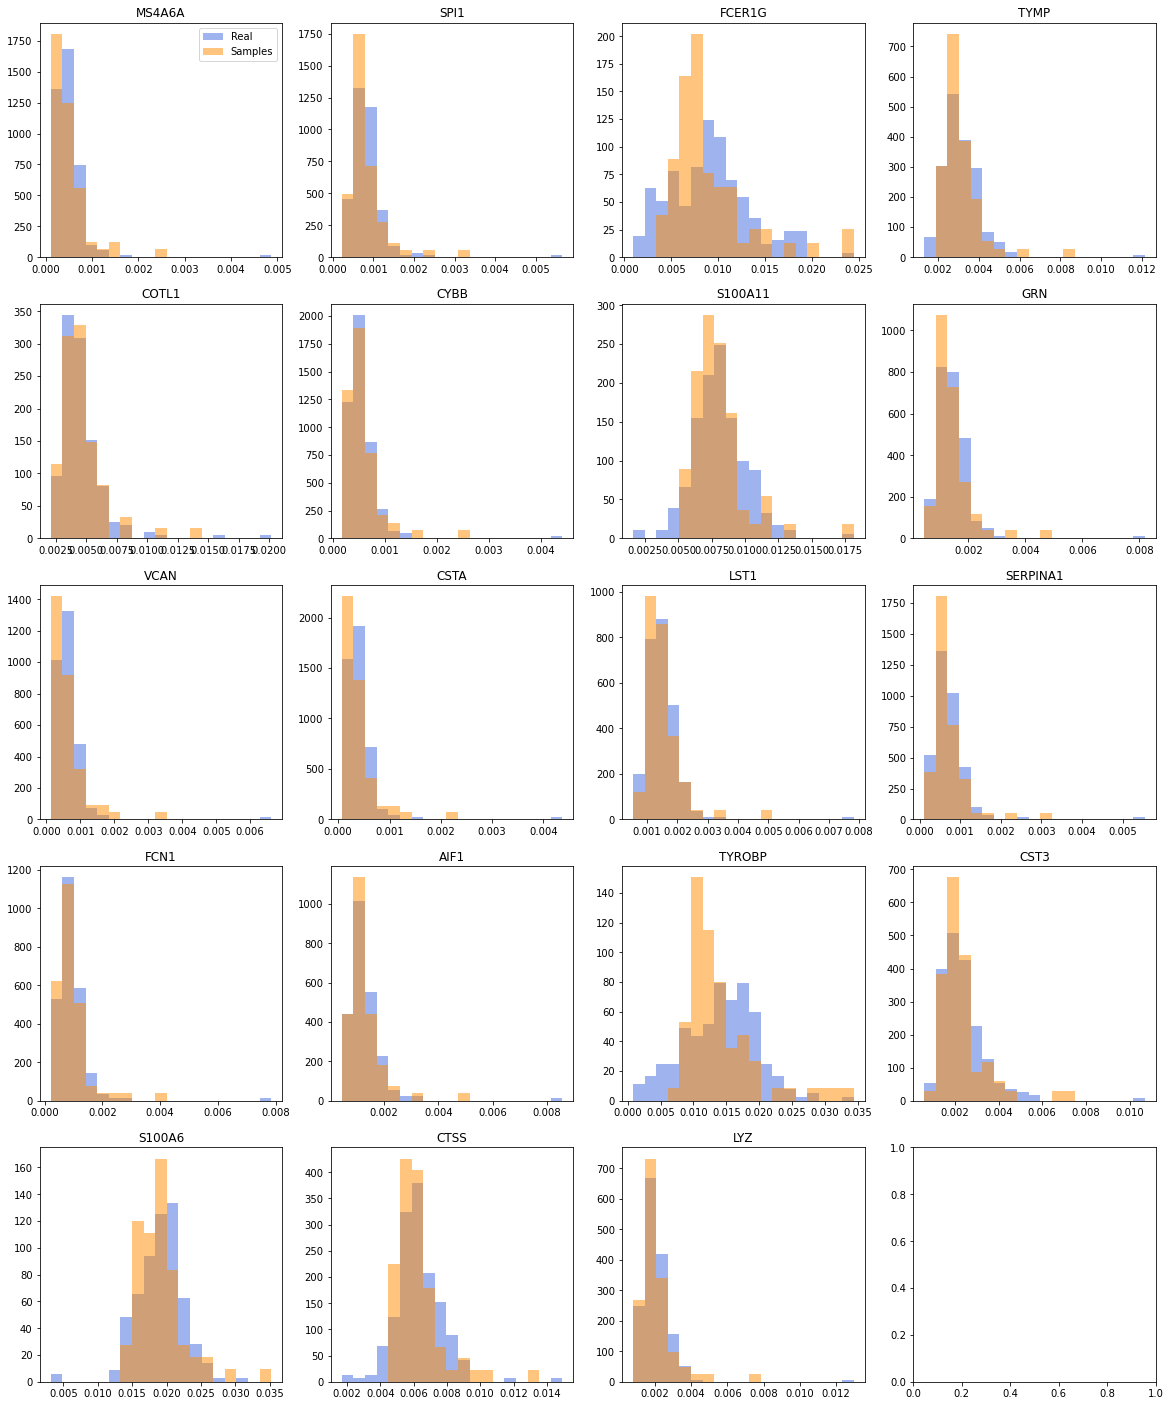

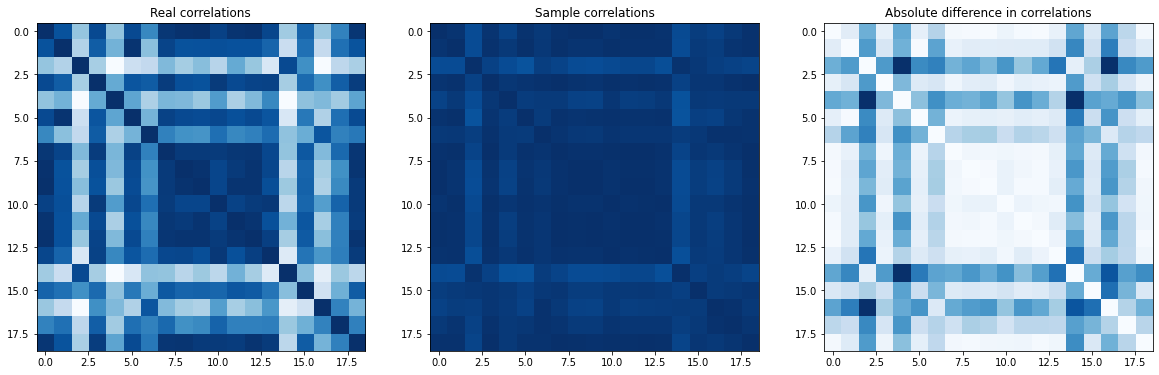

Class 2


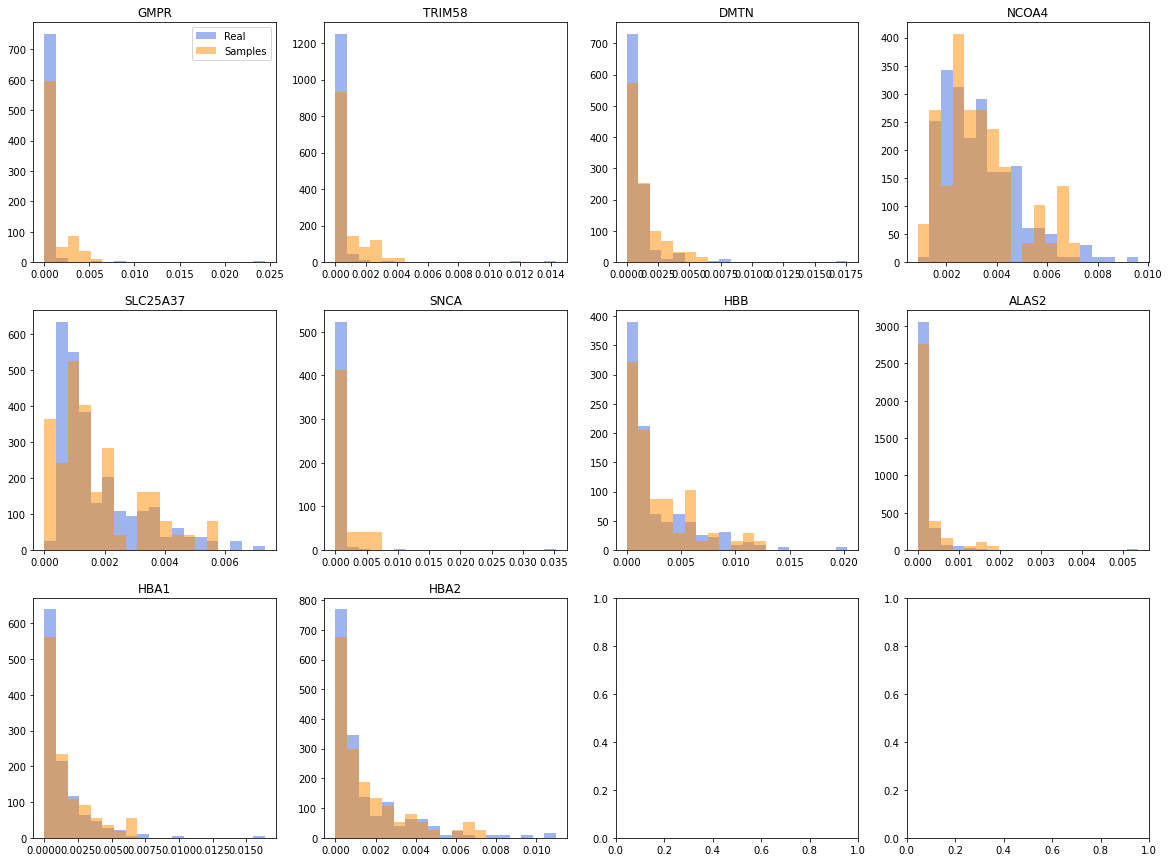

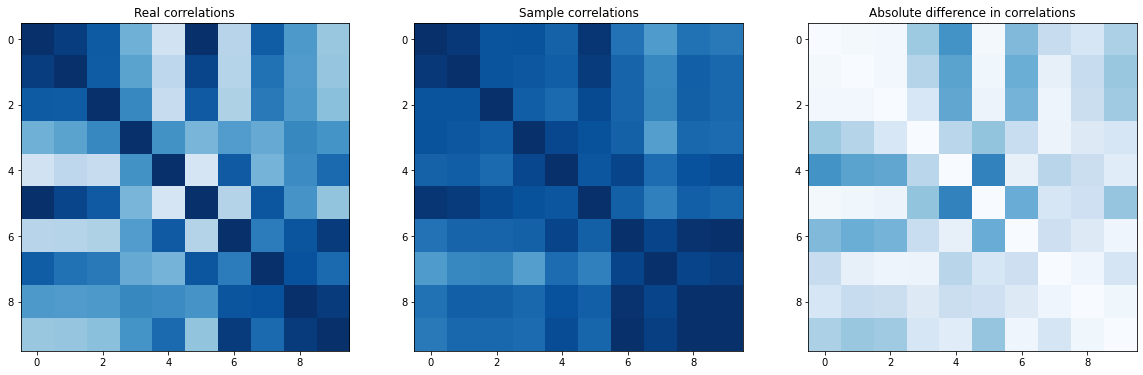

Class 3


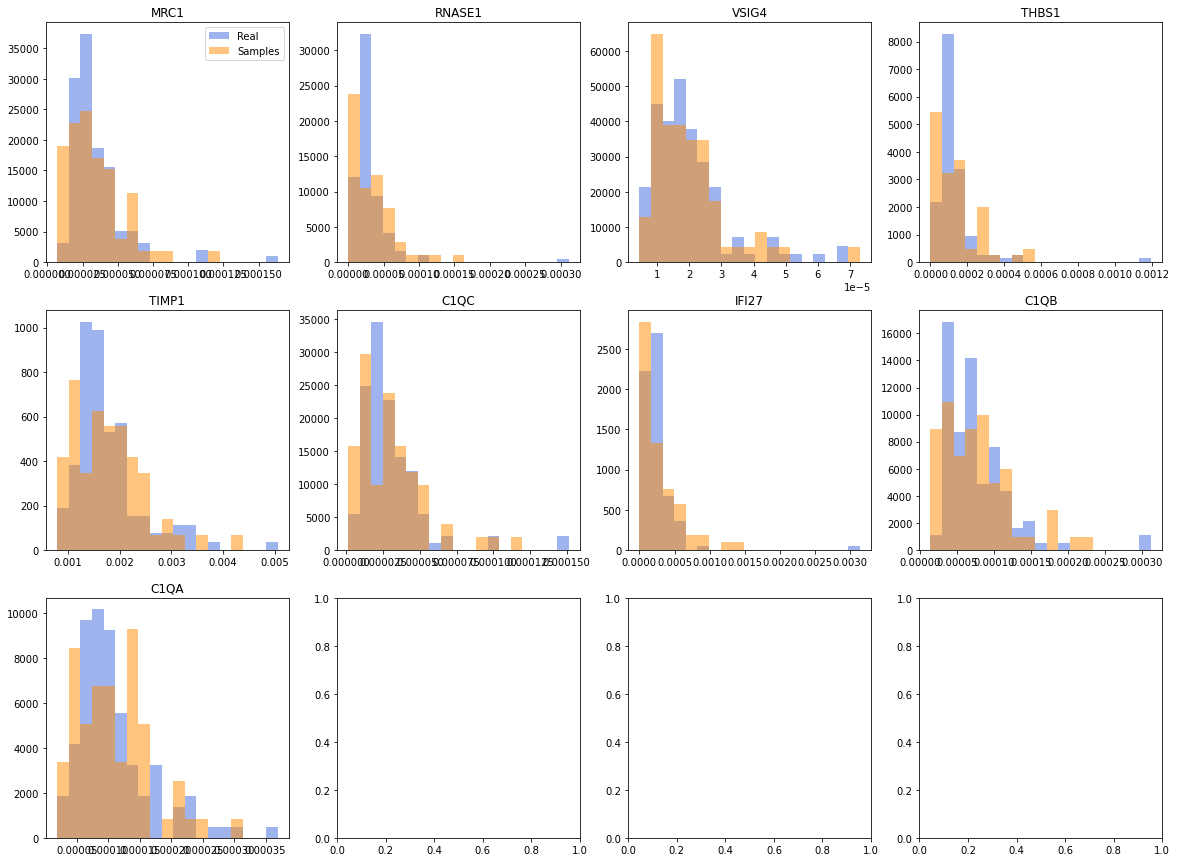

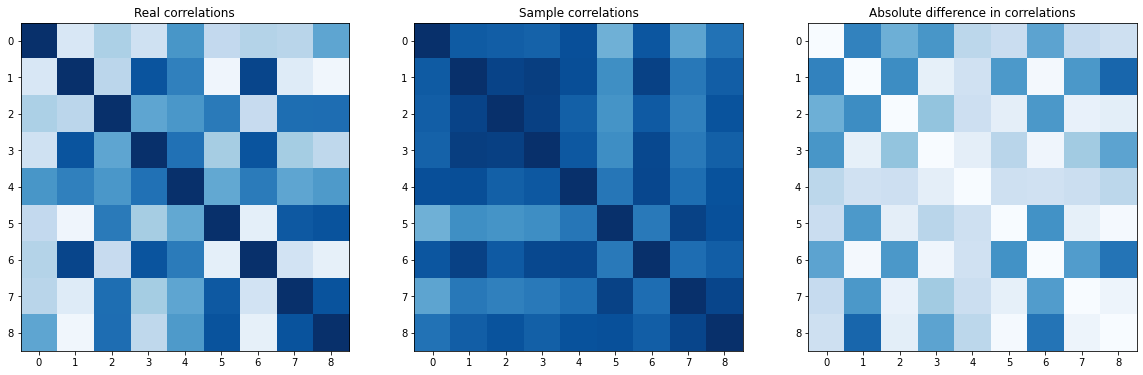

Class 4


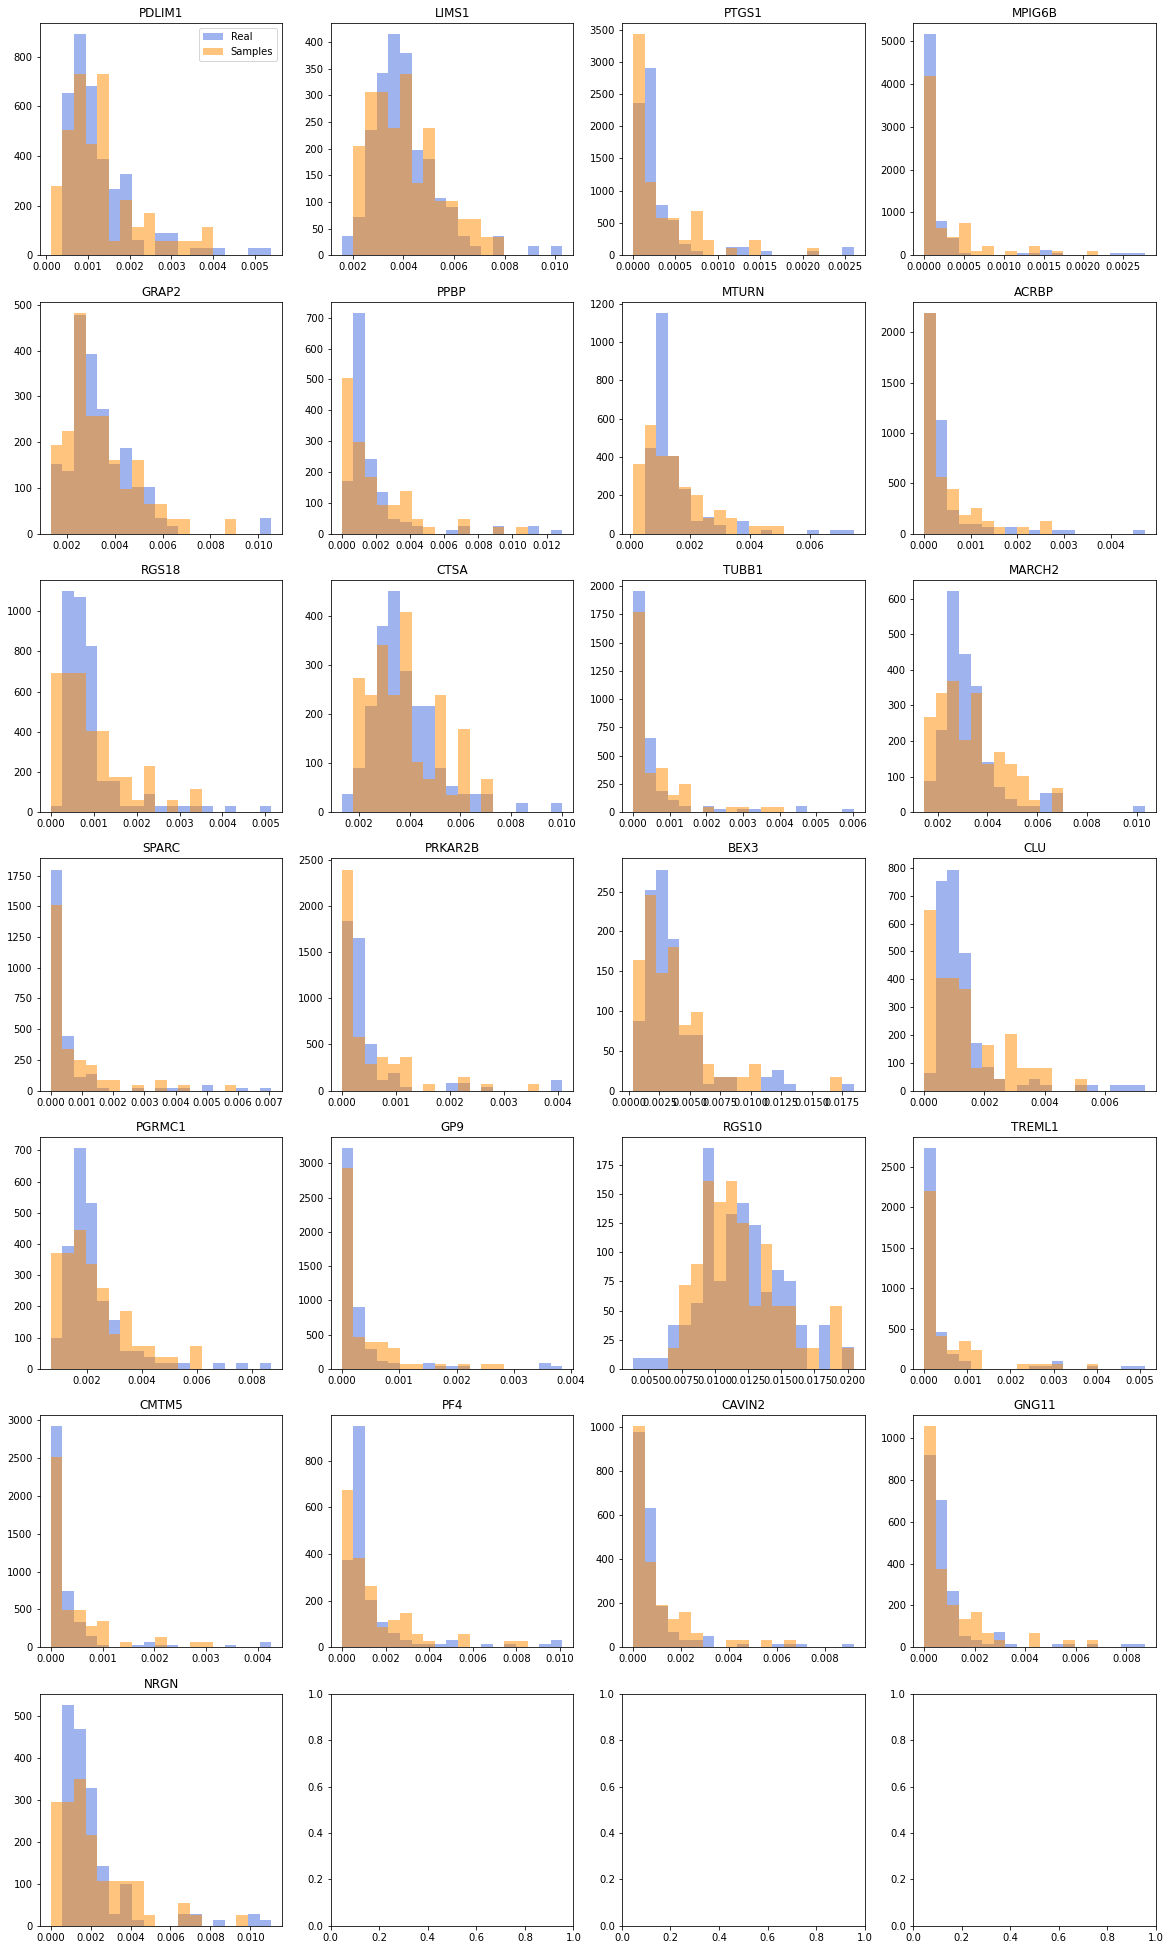

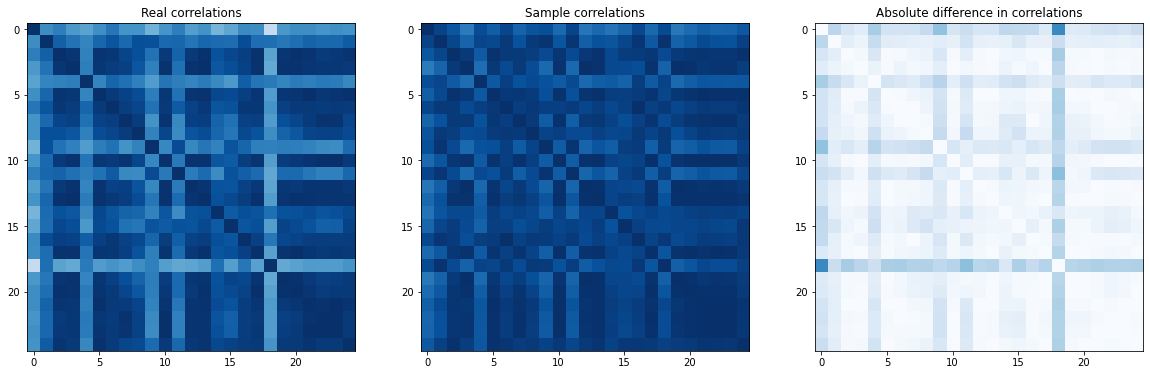

Class 5


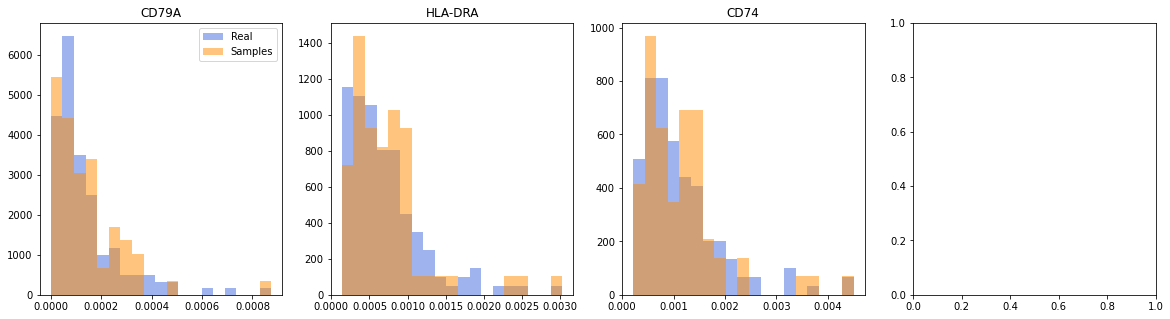

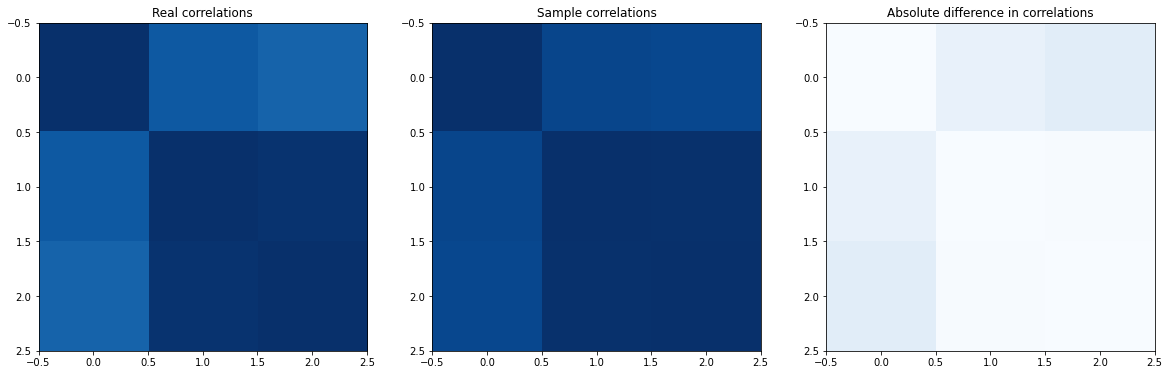

Class 7


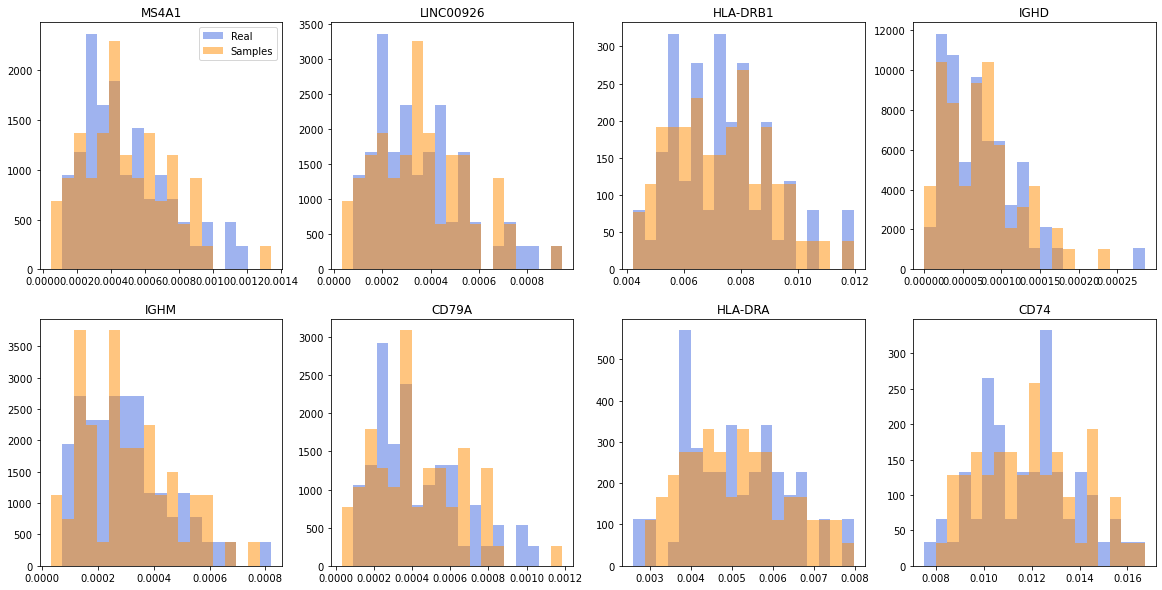

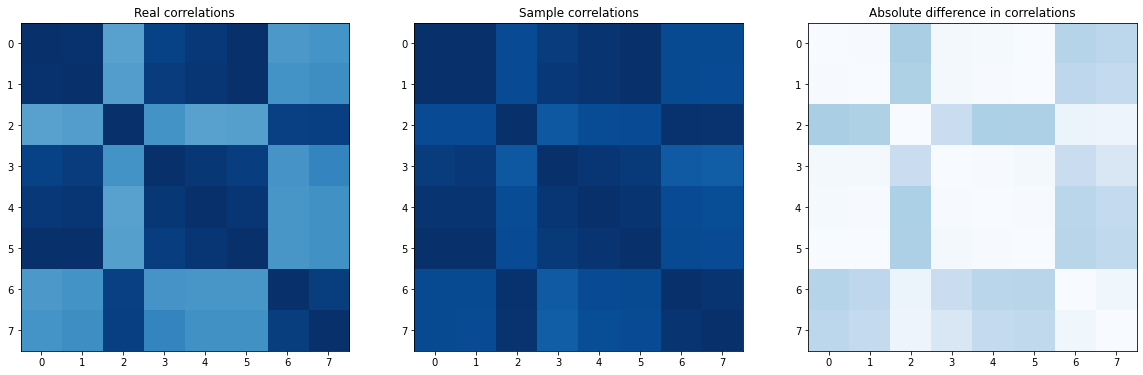

Class 10
Class 12


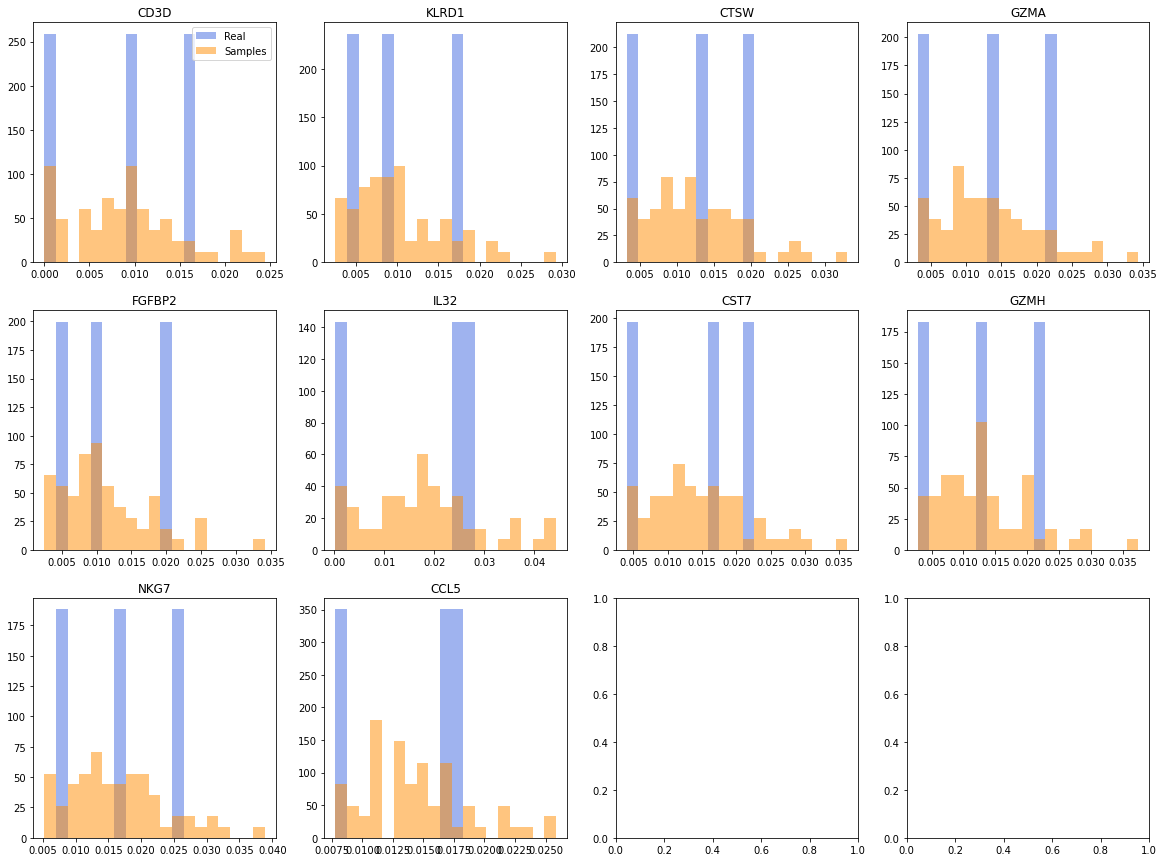

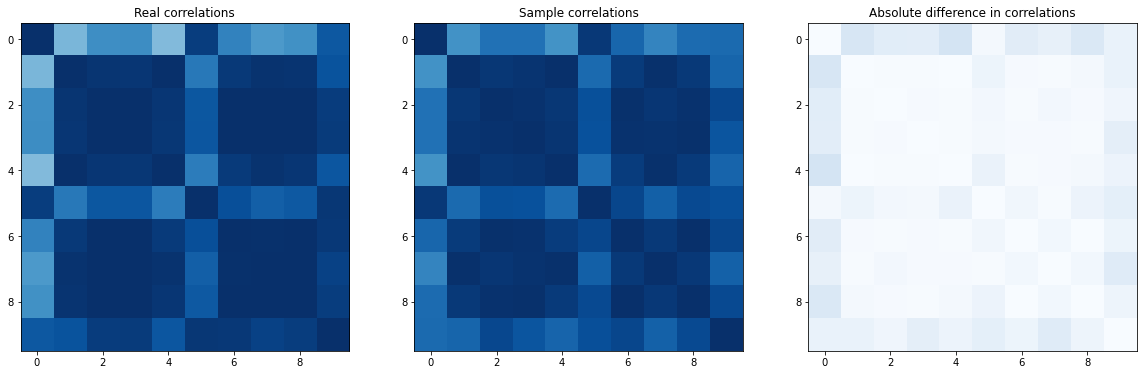

In [14]:
for class_to_sample in classes:
    print("Class %s" % class_to_sample)
    real = data[targets == class_to_sample]
    sample = samples_scaled[class_to_sample]
    
    # Decide which features to plot
    feature_inds = []
    for gene in marker_genes[class_to_sample]:
        if gene in gene_names:
            feature_inds.append(np.where(gene_names == gene)[0][0])
    num_features = len(feature_inds)
    
    if not num_features:
        continue
    
    num_cols = 4
    num_rows = int(np.ceil(num_features / num_cols))
    num_bins = 20

    # Plot feature values
    fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
    if num_rows == 1:
        ax = [ax]
    for i, f_i in enumerate(feature_inds):
        r, c = i // num_cols, i % num_cols
        real_vals = real[:, f_i]
        sample_vals = sample[:, f_i]
        sample_vals[sample_vals < 0] = 0  # Threshold to 0
        all_vals = np.concatenate([real_vals, sample_vals])
        bins = np.linspace(np.min(all_vals), np.max(all_vals), num_bins)
        ax[r][c].hist(real_vals, bins=bins, color="royalblue", label="Real", density=True, alpha=0.5)
        ax[r][c].hist(sample_vals, bins=bins, color="darkorange", label="Samples", density=True, alpha=0.5)
        ax[r][c].set_title(gene_names[f_i])
    ax[0][0].legend()
    plt.show()

    # Compute and plot correlations
    real_corrs = np.empty((num_features, num_features))
    sample_corrs = np.empty_like(real_corrs)
    for i, f_i in enumerate(feature_inds):
        real_corrs[i, i] = 1
        sample_corrs[i, i] = 1
        for j in range(i):
            f_j = feature_inds[j]
            real_corrs[i, j] = scipy.stats.pearsonr(real[:, f_i], real[:, f_j])[0]
            real_corrs[j, i] = real_corrs[i, j]
            sample_corrs[i, j] = scipy.stats.pearsonr(sample[:, f_i], sample[:, f_j])[0]
            sample_corrs[j, i] = sample_corrs[i, j]

    fig, ax = plt.subplots(ncols=3, figsize=(20, 10))
    ax[0].imshow(real_corrs, cmap="Blues", vmin=0, vmax=1)
    ax[0].set_title("Real correlations")
    ax[1].imshow(sample_corrs, cmap="Blues", vmin=0, vmax=1)
    ax[1].set_title("Sample correlations")
    ax[2].imshow(np.abs(real_corrs - sample_corrs), cmap="Blues", vmin=0, vmax=1)
    ax[2].set_title("Absolute difference in correlations")
    plt.show()

### FID

In [15]:
for class_to_sample in classes:
    print("Class %s" % class_to_sample)
    real = data[targets == class_to_sample]
    sample = samples_scaled[class_to_sample]
    fid_score = fid.compute_fid(real, sample)
    print(fid_score)

Class 0
0.001321998436682466
Class 1
0.0023638368604193415
Class 2
0.0025657301705826166
Class 3
0.0012322625065627141
Class 4
0.0007974232685426124
Class 5
0.0019834029419900003
Class 7
0.0006518524702180508
Class 10
0.0014100526908650932
Class 12
0.0033814291962158986
